# Introduction & Table of Contents

I have written notes throughout this notebook to describe a little what I am doing since everything was done in R and not Python.

The important files are the following:
"ets_notebook.ipynb", "submission.csv", "TSfeatures_train_val.csv", "TSfeatures_test.csv", "test.csv" and "train.csv".

<ul>
<li> The "ets_notebook.ipynb" documents everything that I did so that you do not have to re-create / re-run everything. </li>
<li> The "submission.csv" is the final submission - it contains a prediction probability and a binary variable of either "synthetic" or "real". </li>
<li> The "TSfeatures_train_val.csv" consist of the data I created which is fed into the Machine Learning classifier (XGBoost). </li>
<li> The "TSfeatures_test.csv" are the time series features fed to the out-of-sample test data. </li>
<li> The "train.csv" and "test.csv" are the train and test dataset that ETS provided. </li>

</ul>

Part 1 of the notebook:
<ul>
<li> Cleans the data and puts it into a better format for analysis. </li>
<li> Simple plot of some returns for the Synthetic and Real financial time series. </li>
<li> Box-plots of average returns and standard deviations. </li>
<li> Computes the Durbin-Watson test statistics for both Synthetic and Real time series and box-plots. </li>
<li> Plot the 10 day rolling mean and standard deviations for a random time series for Synthetic and real data. </li>
<li> Dickey Fuller test on both the Synthetic and real time series. </li>
<li> Jarque-Bera Test For Normality on the Synthetic and real time series. </li>
<li> ACF Plots for both the Synthetic and real time series. </li>
</ul>

Part 2 of the notebook:

<ul>
<li> Creates the time series features. </li>
<li> Splits the train.csv into "train" and "validation" datasets. </li>
<li> Puts the data into the correct format for XGBoost. </li>
<li> Sets up and search over a parameter space to find the most optimal parameters for this dataset (on the train data). </li>
<li> Outputs these parameters into a dataframe. </li>
<li> Train the model using the optimal parameters found from the grid-search. </li>
<li> Plot the feature importance scores - i.e. the most "important" variables that the model found when making its predictions. </li>
<li> Assign a cut-off on the probability scores (> 0.5 then assign a 1 - real time series, <= 0.5 then assign a 0 for Synthetic). </li>
<li> Compute the Confusion Matrix and analyse the 'in-sample' validation results. </li>
</ul>

Part 3 of the notebook:

<ul>
<li> Create the "test.csv" feautres just as before and save as "TSfeatures_test.csv". </li>
<li> Load in the "TSfeatures_train_val.csv" and "TSfeatures_test.csv" which were created from "train.csv" and "test.csv". </li>
<li> Set up and run the XGBoost model using the optimal parameters found from the cross-validation grid search in "Part 2". </li>
<li> Plot the predicted probability density plot as before in "Part 2". </li>
<li> Set the cut-off threshold as the mean prediction score (0.465) which is close to the (0.500) score from "Part 2". </li>
<li> Save the results as "submission.csv". </li>
</ul>

In [35]:
list.files()

[1] "data.csv"                 "ets_model_3.R"           
 [3] "ETS_model.R"              "ets_notebook.ipynb"      
 [5] "md5_hashes.docx"          "reto_data_science.pdf"   
 [7] "sample_submission.csv"    "submission.csv"          
 [9] "submission2.csv"          "test.7z"                 
[11] "test.csv"                 "train.7z"                
[13] "train.csv"                "TSfeatures_test.csv"     
[15] "TSfeatures_train_val.csv" "TSfeatures.csv"

In [12]:
rm(list = ls())
options(scipen=999)
setwd('C:/Users/Matt/Desktop/Data Science Challenge')
shhh <- suppressPackageStartupMessages

shhh(library(dplyr))
library(readr)
library(TSrepr)
library(ggplot2)
library(data.table)
library(cluster)
library(clusterCrit)
library(fractalrock)
library(cowplot)
library(tidyr)
library(tidyquant)
library(lmtest)
library(aTSA)
library(tsoutliers)
library(tsfeatures)
library(xgboost)
library(caret)

train_val <- read_csv("train.csv")
test <- read_csv("test.csv")

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


# PART 1:

In [13]:
######################################################################
################# Clean the data #####################################

# Since the "features" are daily time series, I just choose a random year and rename the feautres into more meaningful names
# Such as "2010-01-01", "2010-01-02", "2010-01-03" instead of "feature1", "feature2", "feature3" etc.
# Theres a "trading dates" package in R to get only the dates which are trading dates.
colnames(train_val) <- getTradingDates('2010-01-01', obs = 260)
colnames(train_val)[ncol(train_val)] <- "class"
colnames(test) <- getTradingDates('2010-01-01', obs = 260)
test$dataset <- "test"
train_val$dataset <- "train"

In [33]:
######################################################################
################# Rearrange the data #################################

# I melt the data for easier analysis, now the data is in a long format.

# "Class" corresponds to whether the asset is Synthetic or Real
# "Dataset" tells me where the data came from
# "row_id" - corresponds to a unique ID assigned to each asset both "(Synthetic & Real)"
# "Variable" is the column names of the original dataset (feature1, feature2, ... , featureN) converted to some date
# "Value" is the daily returns

df <- train_val %>%
  mutate(row_id = row_number()) %>%
  melt(., measure.vars = 1:260) %>%
  arrange(row_id)

head(df)
dim(df)

class,dataset,row_id,variable,value
0,train,1,2009-01-05,0.006286455
0,train,1,2009-01-06,0.004407363
0,train,1,2009-01-07,-0.038088652
0,train,1,2009-01-08,0.025285012
0,train,1,2009-01-09,-0.006578773
0,train,1,2009-01-12,0.005713677


[1] 3120000       5

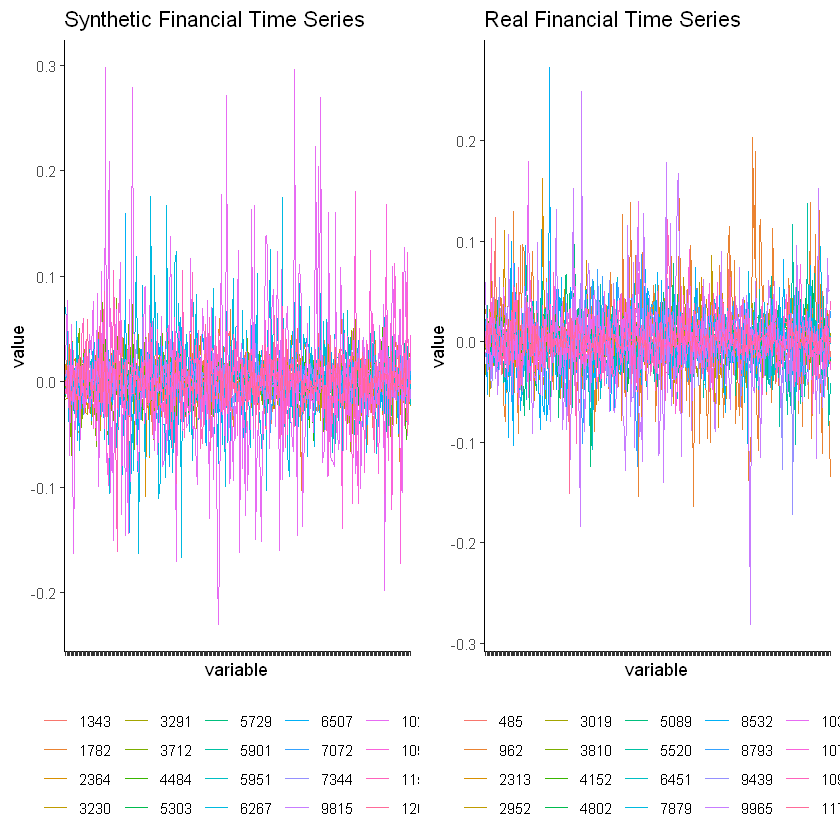

In [34]:
# Plot some returns - I only plot a random sample of 20 assets for each Synthetic vs Real.

ret_plot0 <- df %>%
  filter(class == 0) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(20) %>%
  unnest() %>%
  ggplot(aes(x = variable, y = value)) +
  geom_line(aes(group = factor(row_id), color = factor(row_id))) +
  ggtitle("Synthetic Financial Time Series") +
  theme_classic() +
  theme(axis.text.x = element_blank(), legend.position = "bottom", legend.title = element_blank())


ret_plot1 <- df %>%
  filter(class == 1) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(20) %>%
  unnest() %>%
  ggplot(aes(x = variable, y = value)) +
  geom_line(aes(group = factor(row_id), color = factor(row_id))) +
  ggtitle("Real Financial Time Series") +
  theme_classic() +
  theme(axis.text.x = element_blank(), legend.position = "bottom", legend.title = element_blank())

plot_grid(ret_plot0, ret_plot1)

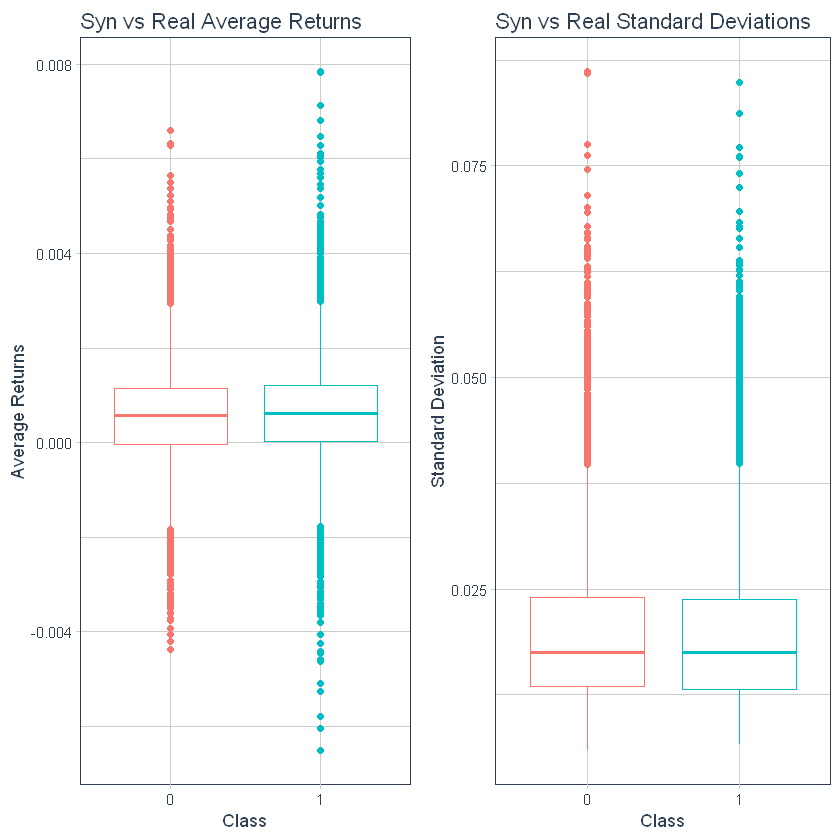

In [35]:
# I compute the average returns and standard deviations over the period for all asssets and compare each class.

ave_box <- df %>%
  group_by(class, row_id) %>%
  summarise(mean = mean(value)) %>%
  ggplot(aes(x = factor(class), y = mean, color = factor(class))) +
  geom_boxplot(show.legend = FALSE) +
  ggtitle("Syn vs Real Average Returns") +
  xlab("Class") +
  ylab("Average Returns") +
  theme_tq()

sd_box <- df %>%
  group_by(class, row_id) %>%
  summarise(sd = sd(value)) %>%
  ggplot(aes(x = factor(class), y = sd, color = factor(class))) +
  geom_boxplot(show.legend = FALSE) +
  ggtitle("Syn vs Real Standard Deviations") +
  xlab("Class") +
  ylab("Standard Deviation") +
  theme_tq()

plot_grid(ave_box, sd_box)

In [39]:
# I calculate the Durbin-Watson statistic and use the "tidy()" function to summarise the key information from the calculation.

dw_test_class_zero <- df %>%
  dplyr::filter(class == 0) %>%
  nest(-row_id) %>%
  mutate(dw_res = map(data, ~ broom::tidy(lmtest::dwtest(value ~ 1, data = .x)))) %>%
  unnest(dw_res) %>%
  mutate(class = "0")

In [40]:
# Here I do the exact same thing as above but this time for the class == 1 data.

dw_test_class_one <- df %>%
  filter(class == 1) %>%
  nest(-row_id) %>%
  mutate(dw_res = map(data, ~ broom::tidy(lmtest::dwtest(value ~ 1, data = .x)))) %>%
  unnest(dw_res) %>%
  mutate(class = "1")

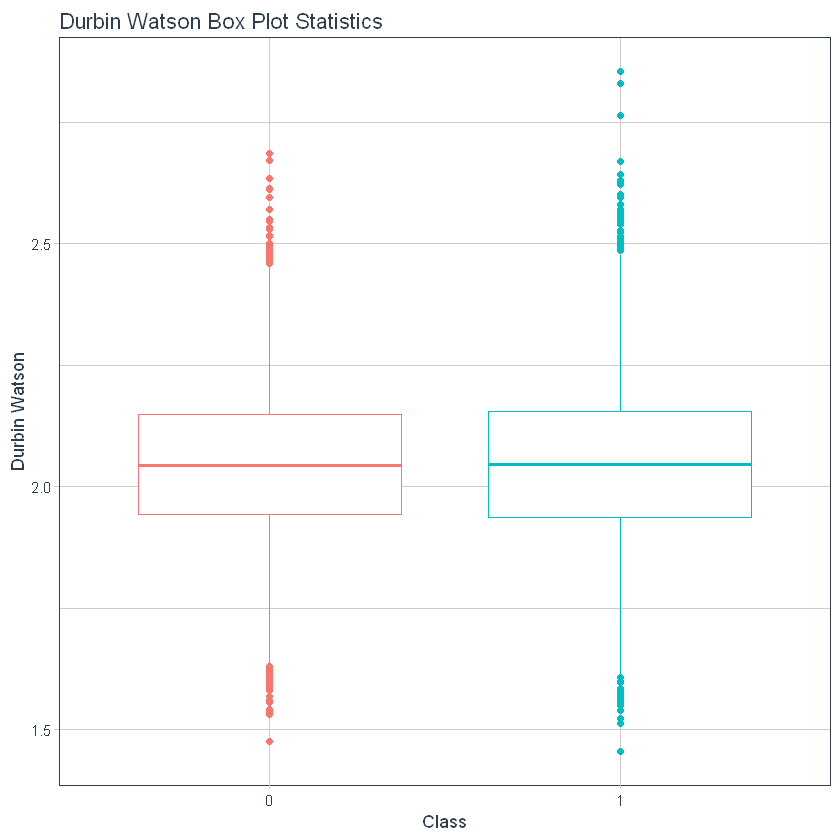

In [41]:
# I bind the rows together and plot a box-plot.

rbind(dw_test_class_zero, dw_test_class_one) %>%
  group_by(class) %>%
  ggplot(aes(x = factor(class), y = statistic, color = factor(class))) +
  geom_boxplot(show.legend = FALSE) +
  ggtitle("Durbin Watson Box Plot Statistics") +
  xlab("Class") +
  ylab("Durbin Watson") +
  theme_tq()

Warning message:
“Removed 18 rows containing missing values (geom_path).”Warning message:
“Removed 18 rows containing missing values (geom_path).”

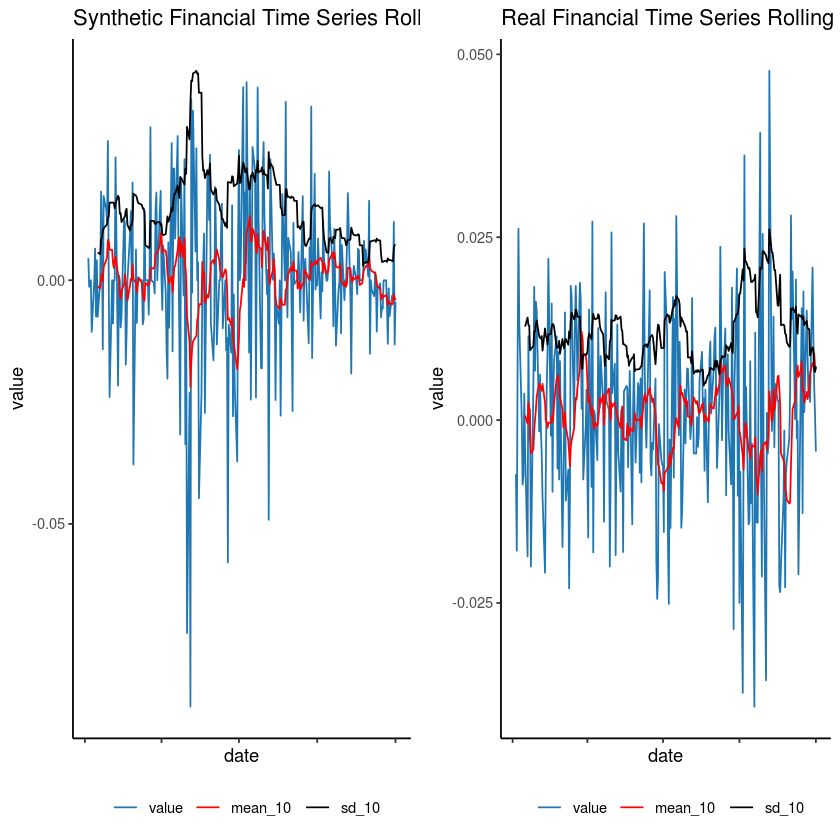

In [9]:
# Rolling mean and standard deviations
# I only use a random sample of 1 of each class of the grouped observations to save on memory and to make the plot more readable.
# The rollowing window is 10 days
# I use the tq_mutate functionality from the "tidyquant" package to keep things in a "tidy" format as per the "tidyverse" 'rules'.
# In the plot "value" is the returns, "mean_10" is the 10 day rolling mean and "sd_10" is the 10 day rolling standard deviation.

plot0 <- df %>%
  filter(class == 0) %>%
  as_tibble() %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  mutate(variable = as.Date(variable)) %>%
  tq_mutate(
    select     = value,
    mutate_fun = rollapply,
    width      = 10,
    align      = "right",
    FUN        = mean,
    na.rm      = TRUE,
    col_rename = "mean_10"
    ) %>%
  tq_mutate(
    select     = value,
    mutate_fun = rollapply,
    width      = 10,
    align      = "right",
    FUN        = sd,
    na.rm      = TRUE,
    col_rename = "sd_10"
    ) %>%
  melt(measure.vars = 5:7) %>%
  setNames(c("row_id", "class", "dataset", "date", "variable", "value")) %>%
  ggplot(aes(x = date)) +
  geom_line(aes(y = value, colour = variable)) +
  ggtitle("Synthetic Financial Time Series Rolling Mean and Standard Deviation") +
  theme_classic() +
  scale_colour_manual(values = c("#1f77b4", "red", "black")) +
  theme(axis.text.x = element_blank(), legend.position = "bottom", legend.title = element_blank())

plot1 <- df %>%
  filter(class == 1) %>%
  as_tibble() %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  mutate(variable = as.Date(variable)) %>%
  tq_mutate(
    select     = value,
    mutate_fun = rollapply,
    width      = 10,
    align      = "right",
    FUN        = mean,
    na.rm      = TRUE,
    col_rename = "mean_10"
  ) %>%
  tq_mutate(
    select     = value,
    mutate_fun = rollapply,
    width      = 10,
    align      = "right",
    FUN        = sd,
    na.rm      = TRUE,
    col_rename = "sd_10"
  ) %>%
  melt(measure.vars = 5:7) %>%
  setNames(c("row_id", "class", "dataset", "date", "variable", "value")) %>%
  ggplot(aes(x = date)) +
  geom_line(aes(y = value, colour = variable)) +
  ggtitle("Real Financial Time Series Rolling Mean and Standard Deviation") +
  theme_classic() +
  scale_colour_manual(values = c("#1f77b4", "red", "black")) +
  theme(axis.text.x = element_blank(), legend.position = "bottom", legend.title = element_blank())  

plot_grid(plot0, plot1)

In [10]:
# Dickey Fuller test on the 0 class
# I only randomly sample 1 of the assets for the 0 class to save on output space

df %>%
  filter(class == 0) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  nest(-row_id) %>%
  mutate(adf_res = map(data, ~ adf.test(.x$value))) %>%
  unnest(adf_res)


Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -17.11    0.01
[2,]   1 -11.01    0.01
[3,]   2  -9.47    0.01
[4,]   3  -9.09    0.01
[5,]   4  -8.61    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -17.13    0.01
[2,]   1 -11.03    0.01
[3,]   2  -9.50    0.01
[4,]   3  -9.16    0.01
[5,]   4  -8.67    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -17.16    0.01
[2,]   1 -11.08    0.01
[3,]   2  -9.55    0.01
[4,]   3  -9.19    0.01
[5,]   4  -8.78    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


row_id,adf_res
<int>,<list>
6742,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -17.114508, -11.013833, -9.465615, -9.085421, -8.609105, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"
6742,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -17.128116, -11.033299, -9.504570, -9.157584, -8.669078, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"
6742,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -17.156757, -11.081321, -9.545201, -9.185512, -8.780369, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"


In [11]:
# Dickey Fuller test on the 1 class
# I only randomly sample 1 of the assets for the 1 class to save on output space

df %>%
  filter(class == 1) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  nest(-row_id) %>%
  mutate(adf_res = map(data, ~ adf.test(.x$value))) %>%
  unnest(adf_res)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -16.37    0.01
[2,]   1 -12.03    0.01
[3,]   2 -10.19    0.01
[4,]   3  -9.02    0.01
[5,]   4  -7.52    0.01
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -16.50    0.01
[2,]   1 -12.22    0.01
[3,]   2 -10.41    0.01
[4,]   3  -9.29    0.01
[5,]   4  -7.82    0.01
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -16.47    0.01
[2,]   1 -12.19    0.01
[3,]   2 -10.39    0.01
[4,]   3  -9.27    0.01
[5,]   4  -7.80    0.01
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


row_id,adf_res
<int>,<list>
11085,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -16.371976, -12.029433, -10.186513, -9.017429, -7.522447, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"
11085,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -16.501759, -12.215099, -10.411252, -9.290359, -7.819255, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"
11085,"0.000000, 1.000000, 2.000000, 3.000000, 4.000000, -16.469330, -12.190427, -10.391839, -9.271585, -7.801521, 0.010000, 0.010000, 0.010000, 0.010000, 0.010000"


In [12]:
##################### Jarque-Bera Test For Normality #####

# For both classes I take a random sample of 1 observation from each class (Synthetic and Real financial series)

jb_zero <- df %>%
  filter(class == 0) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  nest(-row_id) %>%
  mutate(JarqueBeraTest = map(data, ~ JarqueBera.test(.x$value)))

print("Jarque-Bera Test on the 0 - Synthetic class")
jb_zero$JarqueBeraTest

jb_one <- df %>%
  filter(class == 0) %>%
  group_by(row_id) %>%
  nest() %>%
  sample_n(1) %>%
  unnest() %>%
  nest(-row_id) %>%
  mutate(JarqueBeraTest = map(data, ~ JarqueBera.test(.x$value)))

print("Jarque-Bera Test on the 1 - Real class")
jb_one$JarqueBeraTest

[1] "Jarque-Bera Test on the 0 - Synthetic class"


[[1]]

	Jarque Bera Test

data:  .x$value
X-squared = 3.2039, df = 2, p-value = 0.2015


	Skewness

data:  .x$value
statistic = 0.065126, p-value = 0.6681


	Kurtosis

data:  .x$value
statistic = 3.528, p-value = 0.08224



[1] "Jarque-Bera Test on the 1 - Real class"


[[1]]

	Jarque Bera Test

data:  .x$value
X-squared = 85.004, df = 2, p-value < 0.00000000000000022


	Skewness

data:  .x$value
statistic = 0.021118, p-value = 0.8894


	Kurtosis

data:  .x$value
statistic = 5.8008, p-value < 0.00000000000000022



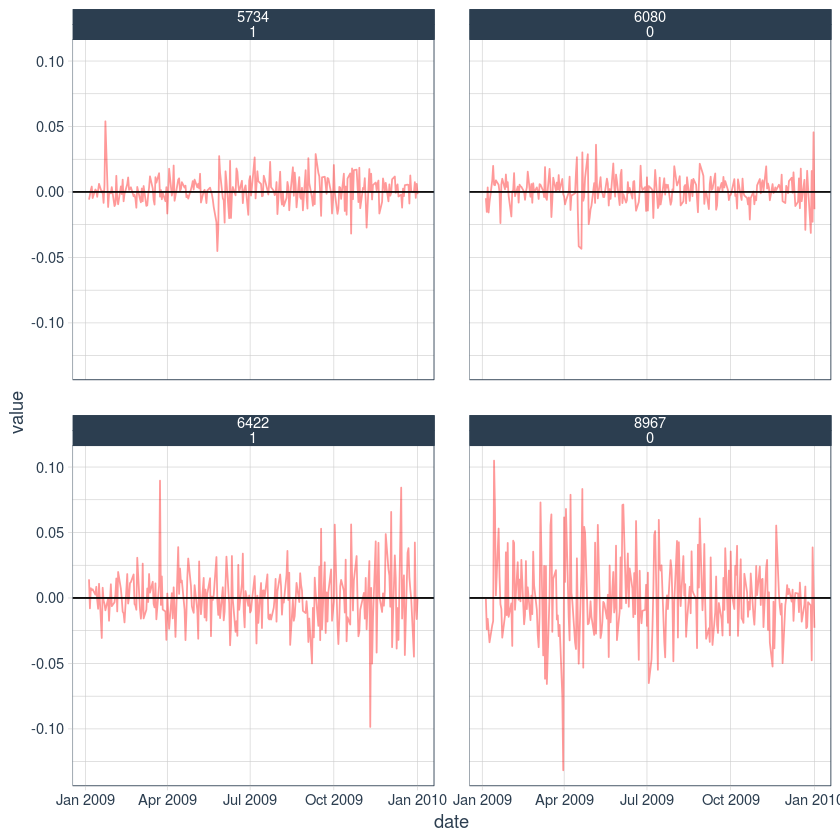

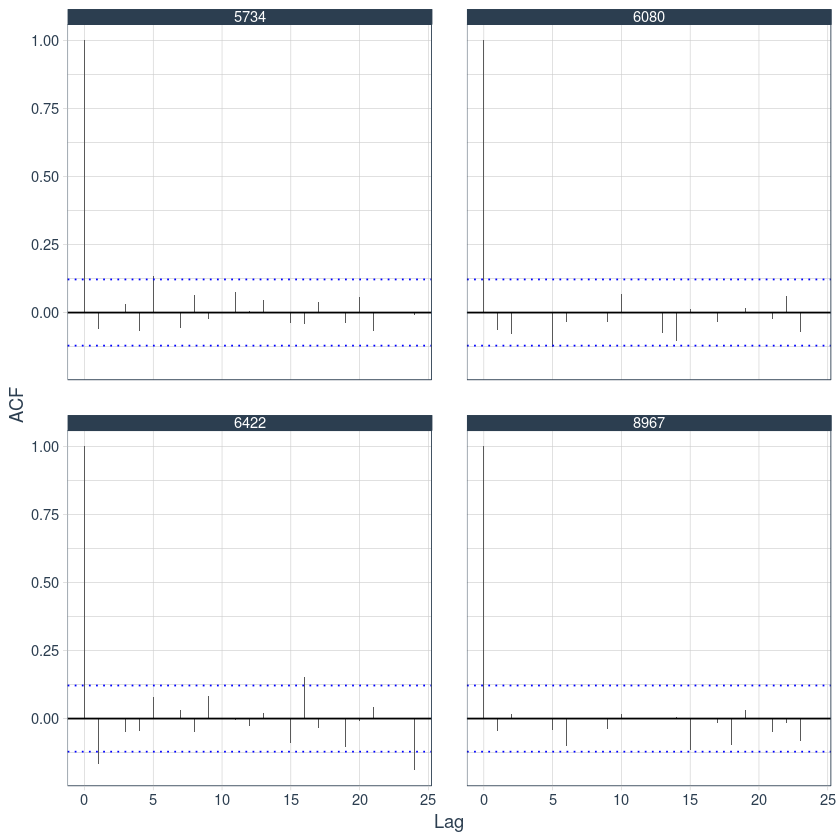

In [13]:
######################################################################
################# ACF plots ##########################################

# I only use 4 observations for these plots, 2 from the "synthetic" class and 2 from the "real" class.

df %>%
  filter(row_id == 6422 | row_id == 8967 | row_id == 6080 | row_id == 	5734) %>%
  mutate(date = as.Date(variable)) %>%
  ggplot(aes(x = date)) +
  geom_line(aes(y = value), color = "red", alpha = 0.4) +
  geom_hline(yintercept = 0) +
  facet_wrap(~ row_id + class) +
  theme_tq()

acf_data <- df %>%
  dplyr::filter(row_id == 6422 | row_id == 8967 | row_id == 6080 | row_id == 	5734) %>%
  mutate(date = as.Date(variable))

df_acf <- acf_data %>%
  group_by(row_id) %>% 
  summarise(list_acf = list(acf(value, plot=FALSE))) %>%
  mutate(acf_vals = purrr::map(list_acf, ~as.numeric(.x$acf))) %>% 
  select(-list_acf) %>% 
  unnest() %>% 
  group_by(row_id) %>% 
  mutate(lag = row_number() - 1)

df_ci <- acf_data %>% 
  group_by(row_id) %>% 
  summarise(ci = qnorm((1 + 0.95)/2)/sqrt(n()))

ggplot(df_acf, aes(x = lag, y = acf_vals)) +
  geom_bar(stat="identity", width=.05) +
  geom_hline(yintercept = 0) +
  geom_hline(data = df_ci, aes(yintercept = -ci), color="blue", linetype="dotted") +
  geom_hline(data = df_ci, aes(yintercept = ci), color="blue", linetype="dotted") +
  labs(x="Lag", y="ACF") +
  facet_wrap(~ row_id) +
  theme_tq()

# ------- END OF DATA ANALYSIS --------

# PART 2:

In [6]:
######################################################################
################# Generate Time Series Features ######################

# I create some time series features from the package "tsfeatures". There are 40+ functions in the "tsfeatures" package
# which can generate approximately 106 time series features.
# Due to memory issues I am only able to create a few of the features, therefore I randomly sample 10 features from the
# "tsfeatures" package. We could also add in technical indicators from the "PerformanceAnalytics" or "TTR" packages (I omit these
# here, however creating 'functions2 <- ls("package:TTR")' and adding it to the 'summarise' command will work.)

functions <- ls("package:tsfeatures")[1:42]
# functions <- sample(functions, 20)

Stats <- df %>%
  group_by(row_id, class) %>%
#  nest() %>%
#  sample_n(5) %>%
#  unnest() %>%
  nest(-row_id, -class) %>%
  group_by(row_id, class) %T>% 
  {options(warn = -1)} %>%
  summarise(Statistics = map(data, ~ data.frame(
    bind_cols(
      tsfeatures(.x$value, functions))))) %>%
  unnest(Statistics)

#print("Generated 106 Time Series features")


# A tibble: 12,000 x 51
# Groups:   row_id [12,000]
   row_id class trev_num_trev_n… unitroot_pp flat_spots embed2_incircle
    <int> <dbl>            <dbl>       <dbl>      <dbl>           <dbl>
 1      1     0           0.121        -250.          4           0.393
 2      2     0          -0.477        -256.          4           0.429
 3      3     1          -0.876        -258.          6           0.467
 4      4     0          -0.994        -262.          7           0.456
 5      5     0          -0.717        -324.          9           0.656
 6      6     0           0.0899       -262.          5           0.435
 7      7     1           0.0132       -254.          7           0.525
 8      8     1           0.167        -243.          6           0.399
 9      9     0           0.288        -234.          5           0.578
10     10     0          -0.115        -246.         10           0.585
# … with 11,990 more rows, and 45 more variables: max_level_shift <dbl>,
#   time_le

In [ ]:
#write.csv(Stats, "TSfeatures_train_val.csv")

In [18]:
Stats <- read.csv("TSfeatures_train_val.csv")
list.files()
head(Stats)

[1] "data.csv"                 "ETS_model.R"             
 [3] "ets_model_3.R"            "ets_notebook.ipynb"      
 [5] "md5_hashes.docx"          "reto_data_science.pdf"   
 [7] "sample_submission.csv"    "submission.csv"          
 [9] "submission2.csv"          "test.7z"                 
[11] "test.csv"                 "train.7z"                
[13] "train.csv"                "TSfeatures.csv"          
[15] "TSfeatures_test.csv"      "TSfeatures_train_val.csv"

X,row_id,class,ac_9_ac_9,acf_features_x_acf1,acf_features_x_acf10,acf_features_diff1_acf1,acf_features_diff1_acf10,acf_features_diff2_acf1,acf_features_diff2_acf10,...,tsfeatures_entropy,tsfeatures_x_acf1,tsfeatures_x_acf10,tsfeatures_diff1_acf1,tsfeatures_diff1_acf10,tsfeatures_diff2_acf1,tsfeatures_diff2_acf10,unitroot_kpss,unitroot_pp,walker_propcross
1,1,0,-0.067527460,0.009709445,0.05268970,-0.5005299,0.3297018,-0.6772403,0.6124739,...,0.9840151,0.009709445,0.05268970,-0.5005299,0.3297018,-0.6772403,0.6124739,0.09938291,-249.7732,0.5405405
2,2,0,-0.042157717,-0.007590195,0.03874814,-0.5171529,0.3129147,-0.6727897,0.5379301,...,0.9864332,-0.007590195,0.03874814,-0.5171529,0.3129147,-0.6727897,0.5379301,0.04145992,-256.0485,0.5019305
3,3,1,0.009959832,-0.040592874,0.04490357,-0.5026683,0.3471209,-0.6718885,0.6109006,...,0.9868568,-0.040592874,0.04490357,-0.5026683,0.3471209,-0.6718885,0.6109006,0.07756983,-258.1295,0.5328185
4,4,0,-0.042874797,-0.044361893,0.06158667,-0.4571442,0.3184053,-0.5906478,0.4361178,...,0.9790521,-0.044361893,0.06158667,-0.4571442,0.3184053,-0.5906478,0.4361178,0.21296332,-262.0781,0.4903475
5,5,0,0.025931211,-0.244783496,0.14691301,-0.5810073,0.4796508,-0.6799229,0.6232529,...,0.9723766,-0.244783496,0.14691301,-0.5810073,0.4796508,-0.6799229,0.6232529,0.15063439,-323.5672,0.5289575
6,6,0,-0.076116613,0.046855578,0.08583475,-0.5253131,0.3438031,-0.6901570,0.6130725,...,0.9806218,0.046855578,0.08583475,-0.5253131,0.3438031,-0.6901570,0.6130725,0.02594138,-262.3484,0.5250965


In [19]:
######################################################################
################# Train and XGBoost model on the TS Features #########

#Stats <- Stats %>%
#  select_if(~sum(!is.na(.)) > 0)

# Split the training set up between train and a small validation set
smp_size <- floor(0.75 * nrow(Stats))
#set.seed(123)
train_ind <- sample(seq_len(nrow(Stats)), size = smp_size)

train <- Stats[train_ind, ]
val <- Stats[-train_ind, ]

In [20]:
# We have 106 time series features for the model to learn from.

x_train <- train %>%
  ungroup() %>%
  select(-class, -row_id, -X) %>%
  as.matrix()

x_val <- val %>%
  ungroup() %>%
  select(-class, -row_id, -X) %>%
  as.matrix()

y_train <- train %>%
  ungroup() %>%
  pull(class)

y_val <- val %>%
  ungroup() %>%
  pull(class)

print("How does the X variables look like?")
x_train %>%
  as_tibble() %>%
  head()

print("How does the Y variables look like?")
y_train %>%
  as_tibble() %>%
  head()

[1] "How does the X variables look like?"


ac_9_ac_9,acf_features_x_acf1,acf_features_x_acf10,acf_features_diff1_acf1,acf_features_diff1_acf10,acf_features_diff2_acf1,acf_features_diff2_acf10,ARCH.LM,autocorr_features_embed2_incircle_1,autocorr_features_embed2_incircle_2,...,tsfeatures_entropy,tsfeatures_x_acf1,tsfeatures_x_acf10,tsfeatures_diff1_acf1,tsfeatures_diff1_acf10,tsfeatures_diff2_acf1,tsfeatures_diff2_acf10,unitroot_kpss,unitroot_pp,walker_propcross
0.023236441,-0.074650971,0.02038917,-0.5603844,0.3214731,-0.6947503,0.5228883,0.02645647,0.4749035,0.6949807,...,0.9907267,-0.074650971,0.02038917,-0.5603844,0.3214731,-0.6947503,0.5228883,0.08418223,-295.5967,0.5637066
0.089101393,-0.005155064,0.13301470,-0.4885461,0.4353276,-0.6773534,0.7858669,0.22605361,0.5907336,0.7451737,...,0.9636886,-0.005155064,0.13301470,-0.4885461,0.4353276,-0.6773534,0.7858669,0.07434871,-225.7176,0.4903475
-0.015845671,0.045232147,0.02809074,-0.4489214,0.2210296,-0.6291573,0.4179265,0.01533997,0.5658915,0.7674419,...,0.9918732,0.045232147,0.02809074,-0.4489214,0.2210296,-0.6291573,0.4179265,0.05921490,-227.0271,0.4633205
-0.040078185,0.024202203,0.06762123,-0.4316614,0.3067859,-0.6202015,0.5529502,0.09864609,0.5891473,0.7674419,...,0.9804658,0.024202203,0.06762123,-0.4316614,0.3067859,-0.6202015,0.5529502,0.09948075,-227.6157,0.5057915
-0.007340002,-0.172831300,0.04932286,-0.5434486,0.3170055,-0.6880143,0.5446340,0.02723756,0.3976834,0.6525097,...,0.9837865,-0.172831300,0.04932286,-0.5434486,0.3170055,-0.6880143,0.5446340,0.07212473,-274.1723,0.5482625
-0.024278095,0.092982193,0.02774284,-0.4618626,0.2562180,-0.6418039,0.4921543,0.11114889,0.5234375,0.6757812,...,0.9831277,0.092982193,0.02774284,-0.4618626,0.2562180,-0.6418039,0.4921543,0.04312335,-232.2476,0.4671815


[1] "How does the Y variables look like?"


value
0
0
0
1
0
1


In [21]:
# XGBoost expects a 'special' type of matrix
dtrain <- xgb.DMatrix(data = as.matrix(x_train), label = y_train, missing = "NaN")
dval <- xgb.DMatrix(data = as.matrix(x_val), label = y_val, missing = "NaN")

In [47]:
######################################################################
################# XGBoost Grid Search to locate Optimal Parameters ###

##############################################################################################################################
# NOTE: This section was taken from the first chapter of my PhD where I needed to search over a parameter space to locate the
# most optimal parameters - I have just adapted it for this problem of Time Series Classification.
# Its simple enough to add parameters and different values - I just optimise a few important parameters from domain knowledge
# of the XGBoost model for this task, i.e depth and eta are quite important in gradient boosting.

# 1) I create a "grid" with different parameter values or combinations of parameter values
# 2) I apply cross validation over the parameter space to fine the most optimal values for the XGBoost model.
# 3) I print the model parameters which give the best train / (in-sample test) results in a data table.
##############################################################################################################################

# Grid Search Parameters:
# 1)
searchGridSubCol <- expand.grid(subsample = c(1), #Range (0,1], default = 1, set to 0.5 will prevent overfitting
                                colsample_bytree = c(1), #Range (0,1], default = 1
                                max_depth = c(5, 8, 14), #Range (0, inf], default = 6
                                min_child = c(1), #Range (0, inf], default = 1
                                eta = c(0.1, 0.05, 0.3), #Range (0,1], default = 0.3
                                gamma = c(0), #Range (0, inf], default = 0
                                lambda = c(1), #Default = 1, L2 regularisation on weights, higher the more conservative the model
                                alpha = c(0), #Default = 0, L1 regularisation on weights, higher the more conservative the model
                                max_delta_step = c(0), #Range (0, inf], default = 0 (Helpful for logisitc regression when class is extremely imbalanced, set to value 1-10 may help control the update)
                                colsample_bylevel = c(1) #Range (0,1], default = 1
                                )

ntrees = 200
nfold <- 10
watchlist <- list(train = dtrain, test = dval)

# 2)
system.time(
  AUCHyperparameters <- apply(searchGridSubCol, 1, function(parameterList){
    #Extract Parameters to test
    currentSubsampleRate <- parameterList[["subsample"]]
    currentColsampleRate <- parameterList[["colsample_bytree"]]
    currentDepth <- parameterList[["max_depth"]]
    currentEta <- parameterList[["eta"]]
    currentMinChild <- parameterList[["min_child"]]
    gamma <- parameterList[["gamma"]]
    lambda <- parameterList[["lambda"]]
    alpha <- parameterList[["alpha"]]
    max_delta_step <- parameterList[["max_delta_step"]]
    colsample_bylevel <- parameterList[["colsample_bylevel"]]
    xgboostModelCV <- xgb.cv(data =  dtrain, 
                             nrounds = ntrees, 
                             nfold = nfold, 
                             showsd = TRUE,
                             metrics = c("auc", "logloss", "error"),
                             verbose = TRUE, 
                             "eval_metric" = c("auc", "logloss", "error"),
                             "objective" = "binary:logistic", #Outputs a probability "binary:logitraw" - outputs score before logistic transformation
                             "max.depth" = currentDepth, 
                             "eta" = currentEta,
                             "gamma" = gamma,
                             "lambda" = lambda,
                             "alpha" = alpha,
                             "subsample" = currentSubsampleRate, 
                             "colsample_bytree" = currentColsampleRate,
                             print_every_n = 50, # print ever 50 trees to reduce the outputs printed.
                             "min_child_weight" = currentMinChild,
                             booster = "gbtree", #booster = "dart"  #using dart can help improve accuracy.
                             early_stopping_rounds = 10,
                             watchlist = watchlist,
                             seed = 1234)
    xvalidationScores <<- as.data.frame(xgboostModelCV$evaluation_log)
    train_auc_mean <- tail(xvalidationScores$train_auc_mean, 1)
    test_auc_mean <- tail(xvalidationScores$test_auc_mean, 1)
    train_logloss_mean <- tail(xvalidationScores$train_logloss_mean, 1)
    test_logloss_mean <- tail(xvalidationScores$test_logloss_mean, 1)
    train_error_mean <- tail(xvalidationScores$train_error_mean, 1)
    test_error_mean <- tail(xvalidationScores$test_error_mean, 1)
    output <- return(c(train_auc_mean, test_auc_mean, train_logloss_mean, test_logloss_mean, train_error_mean, test_error_mean, xvalidationScores, currentSubsampleRate, currentColsampleRate, currentDepth, currentEta, gamma, lambda, alpha, max_delta_step, colsample_bylevel, currentMinChild))
    hypemeans <- which.max(AUCHyperparameters[[1]]$test_auc_mean)
    output2 <- return(hypemeans)
    }))

[1]	train-auc:0.709444+0.005449	train-logloss:0.679352+0.000266	train-error:0.356012+0.007934	test-auc:0.674091+0.017564	test-logloss:0.681697+0.001146	test-error:0.380111+0.011477 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 10 rounds.

[51]	train-auc:0.864482+0.003830	train-logloss:0.509142+0.003445	train-error:0.223012+0.004731	test-auc:0.735318+0.012974	test-logloss:0.599101+0.009049	test-error:0.336111+0.013809 
Stopping. Best iteration:
[67]	train-auc:0.886833+0.004311	train-logloss:0.486189+0.004434	train-error:0.199753+0.005421	test-auc:0.738559+0.013404	test-logloss:0.596390+0.009818	test-error:0.331111+0.013690

[1]	train-auc:0.783311+0.005215	train-logloss:0.670555+0.000708	train-error:0.302667+0.004773	test-auc:0.660515+0.017584	test-logloss:0.680860+0.001373	test-error:0.387444+0.023878 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't 

   user  system elapsed 
1939.63   51.14  654.69 

In [49]:
# 3)
output <- as.data.frame(t(sapply(AUCHyperparameters, '[', c(1:6, 20:29))))
varnames <- c("TrainAUC", "TestAUC", "TrainLogloss", "TestLogloss", "TrainError", "TestError", "SubSampRate", "ColSampRate", "Depth", "eta", "gamma", "lambda", "alpha", "max_delta_step", "col_sample_bylevel", "currentMinChild")
colnames(output) <- varnames
data.table(output)

TrainAUC,TestAUC,TrainLogloss,TestLogloss,TrainError,TestError,SubSampRate,ColSampRate,Depth,eta,gamma,lambda,alpha,max_delta_step,col_sample_bylevel,currentMinChild
0.8977254,0.7390132,0.4742636,0.5954282,0.1878026,0.3330001,1,1,5,0.1,0,1,0,0,1,1
0.9890697,0.743927,0.3319295,0.5932834,0.0536296,0.3293333,1,1,8,0.1,0,1,0,0,1,1
1,0.7584138,0.0662322,0.6039268,0,0.3162223,1,1,14,0.1,0,1,0,0,1,1
0.8493396,0.7336757,0.5263202,0.6021869,0.239679,0.3383333,1,1,5,0.05,0,1,0,0,1,1
0.9430787,0.7322655,0.4642675,0.6055151,0.1377653,0.3396668,1,1,8,0.05,0,1,0,0,1,1
1,0.7518296,0.1698682,0.5901376,0,0.3218888,1,1,14,0.05,0,1,0,0,1,1
0.8932411,0.7239299,0.466469,0.6063663,0.1925431,0.3464445,1,1,5,0.3,0,1,0,0,1,1
1,0.7407583,0.0868916,0.6423666,0.0000738,0.3298889,1,1,8,0.3,0,1,0,0,1,1
1,0.7520043,0.0212522,0.6814635,0,0.3176667,1,1,14,0.3,0,1,0,0,1,1


# Optimal Parameters:

ntrees = 95,

eta = 0.1,

max_depth = 5,

With the other parameters left to default settings for simplicity.

Lets plug them into the XGB model

In [22]:
#################################################################################
################# XGBoost Optimal Parameters from Cross Validation ##############

# This is the final training model where I use the most optimal parameters found over the grid space and plug them in here.

watchlist <- list("train" = dtrain)

params <- list("eta" = 0.1, "max_depth" = 5, "colsample_bytree" = 1, "min_child_weight" = 1, "subsample"= 1,
               "objective"="binary:logistic", "gamma" = 1, "lambda" = 1, "alpha" = 0, "max_delta_step" = 0,
               "colsample_bylevel" = 1, "eval_metric"= "auc",
               "set.seed" = 176)

nround <- 95

In [24]:
# Train the XGBoost model

xgb.model <- xgb.train(params, dtrain, nround, watchlist)
# Note: Plot AUC on for the in-sample train / validation scores

[1]	train-auc:0.705973 
[2]	train-auc:0.719498 
[3]	train-auc:0.734230 
[4]	train-auc:0.740069 
[5]	train-auc:0.745137 
[6]	train-auc:0.746840 
[7]	train-auc:0.754894 
[8]	train-auc:0.759521 
[9]	train-auc:0.761794 
[10]	train-auc:0.764262 
[11]	train-auc:0.771451 
[12]	train-auc:0.773591 
[13]	train-auc:0.778484 
[14]	train-auc:0.781871 
[15]	train-auc:0.784020 
[16]	train-auc:0.784618 
[17]	train-auc:0.786377 
[18]	train-auc:0.789053 
[19]	train-auc:0.794144 
[20]	train-auc:0.794969 
[21]	train-auc:0.796448 
[22]	train-auc:0.800650 
[23]	train-auc:0.804296 
[24]	train-auc:0.807346 
[25]	train-auc:0.808742 
[26]	train-auc:0.810861 
[27]	train-auc:0.813872 
[28]	train-auc:0.814804 
[29]	train-auc:0.817461 
[30]	train-auc:0.819320 
[31]	train-auc:0.822190 
[32]	train-auc:0.825254 
[33]	train-auc:0.828159 
[34]	train-auc:0.829612 
[35]	train-auc:0.830371 
[36]	train-auc:0.832979 
[37]	train-auc:0.834608 
[38]	train-auc:0.836426 
[39]	train-auc:0.838196 
[40]	train-auc:0.841133 
[41]	trai

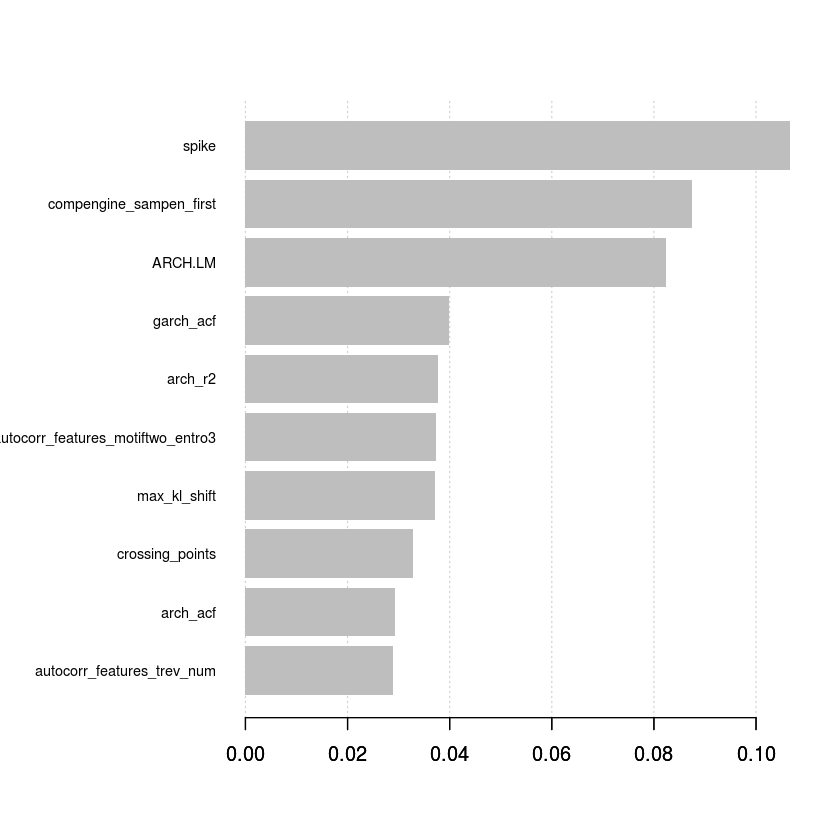

In [17]:
# We can obtain "feature" importance results from the model.
xgb.imp <- xgb.importance(model = xgb.model)
xgb.plot.importance(xgb.imp, top_n = 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


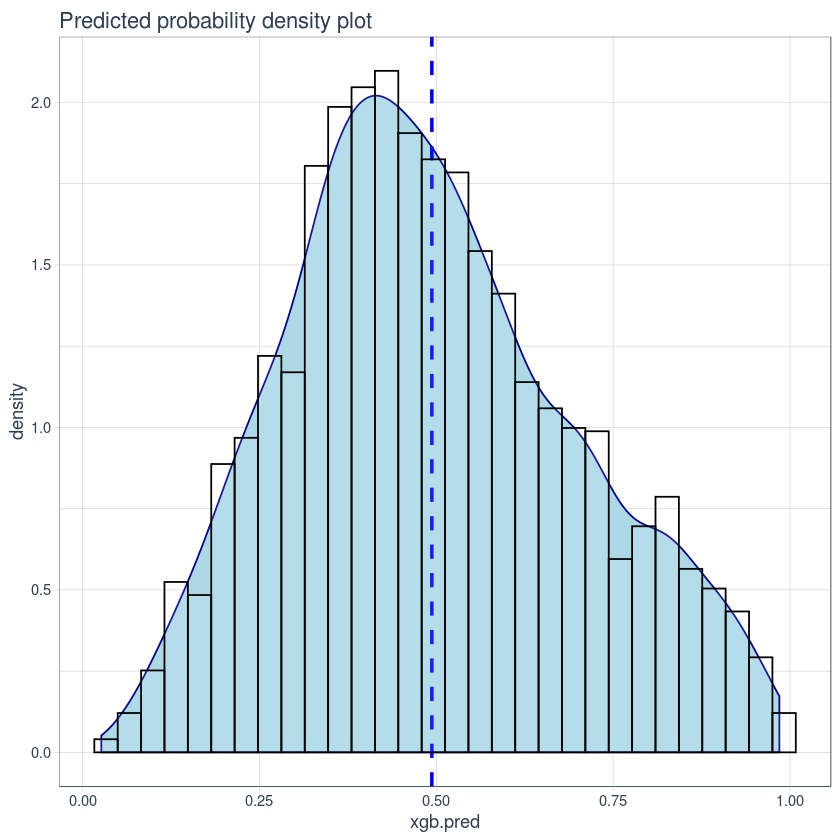

In [27]:
# I next make the predictions on the 'in-sample' held out test set, that is, originally I took the 12,000 training samples
# and split them between 75% training and 25% 'in-sample' testing (9000 training vs 3000 in-sample testing)

# I plot the probabilities from the model - the "dashed" line is the average predicted probability.
xgb.pred <- predict(xgb.model, dval, type = 'prob')

results <- cbind(y_val, xgb.pred)

results %>%
 as.tibble() %>%
 ggplot(aes(x = xgb.pred)) + 
 geom_density(color = "darkblue", fill = "lightblue") +
 geom_vline(aes(xintercept = mean(xgb.pred)),
            color = "blue", linetype = "dashed", size = 1) +
 geom_histogram(aes(y = ..density..), colour = "black", fill = "white", alpha = 0.1, position = "identity") +
 ggtitle("Predicted probability density plot") +
 theme_tq()

In [28]:
# The average predicted probability sits around 0.48 / 0.49, for simplicity I will just select 0.50 as the cut off threshold.
# That is, all observations <= 0.50 are assigned a "0" class or "synthetic" data and all observations >= are assigned a "1" or
# "real" data.
# Finally I output the confusion matrix on the 'in-sample' testing data.

results <- results %>%
  as_tibble() %>%
  mutate(pred = case_when(
    xgb.pred > 0.5 ~ 1,
    xgb.pred <= 0.5 ~ 0
  ))

confusionMatrix(factor(results$pred), factor(results$y_val))

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1103  553
         1  426  918
                                               
               Accuracy : 0.6737               
                 95% CI : (0.6566, 0.6904)     
    No Information Rate : 0.5097               
    P-Value [Acc > NIR] : < 0.00000000000000022
                                               
                  Kappa : 0.346                
                                               
 Mcnemar's Test P-Value : 0.0000565            
                                               
            Sensitivity : 0.7214               
            Specificity : 0.6241               
         Pos Pred Value : 0.6661               
         Neg Pred Value : 0.6830               
             Prevalence : 0.5097               
         Detection Rate : 0.3677               
   Detection Prevalence : 0.5520               
      Balanced Accuracy : 0.6727               
                    

# ------------ END Train - Validation model --------------

# Part 3:

In [4]:
# Not a great results but not terrible either. The model was able to predict with 67% accuracy on the data it had never seen
# before. With better feature selection (from other packages and not just the 'tsfeatures' package) the model will surely 
# increase its accuracy further.

# Next I re-train the model using the whole training sample data (12,000 observations) and make the final prediction on the "test.csv"

# Create the test features

In [54]:
test_final <- read.csv("test.csv") %>%
  mutate(row_id = row_number()) %>%
  melt(., measure.vars = 1:260) %>%
  arrange(row_id)

head(test_final)

row_id,variable,value
1,feature1,0.033103857
1,feature2,0.008622451
1,feature3,0.004062185
1,feature4,0.008255409
1,feature5,0.055874059
1,feature6,-0.006126608


In [ ]:
functions <- ls("package:tsfeatures")[1:42]
# functions <- sample(functions, 20)

test_final <- test_final %>%
  group_by(row_id) %>%
#  nest() %>%
#  sample_n(5) %>%
#  unnest() %>%
  nest(-row_id) %>%
  group_by(row_id) %T>% 
  {options(warn = -1)} %>%
  summarise(Statistics = map(data, ~ data.frame(
    bind_cols(
      tsfeatures(.x$value, functions))))) %>%
  unnest(Statistics)

#print("Generated 106 Time Series features")

In [35]:
# We are HERE @@@@@@@@@@@@@@@@@@@@@@@@@@@

#write.csv(test_final, "TSfeatures_test.csv")

# Load in the train and test features datasets

In [6]:
# I have already created the features for the training dataset so I can just load them right back in as 
train_final <- read.csv("TSfeatures_train_val.csv")
test_final <- read.csv("TSfeatures_test.csv")

head(train_final); dim(train_final)
head(test_final); dim(test_final)

X,row_id,class,ac_9_ac_9,acf_features_x_acf1,acf_features_x_acf10,acf_features_diff1_acf1,acf_features_diff1_acf10,acf_features_diff2_acf1,acf_features_diff2_acf10,⋯,tsfeatures_entropy,tsfeatures_x_acf1,tsfeatures_x_acf10,tsfeatures_diff1_acf1,tsfeatures_diff1_acf10,tsfeatures_diff2_acf1,tsfeatures_diff2_acf10,unitroot_kpss,unitroot_pp,walker_propcross
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,-0.067527460,0.009709445,0.05268970,-0.5005299,0.3297018,-0.6772403,0.6124739,⋯,0.9840151,0.009709445,0.05268970,-0.5005299,0.3297018,-0.6772403,0.6124739,0.09938291,-249.7732,0.5405405
2,2,0,-0.042157717,-0.007590195,0.03874814,-0.5171529,0.3129147,-0.6727897,0.5379301,⋯,0.9864332,-0.007590195,0.03874814,-0.5171529,0.3129147,-0.6727897,0.5379301,0.04145992,-256.0485,0.5019305
3,3,1,0.009959832,-0.040592874,0.04490357,-0.5026683,0.3471209,-0.6718885,0.6109006,⋯,0.9868568,-0.040592874,0.04490357,-0.5026683,0.3471209,-0.6718885,0.6109006,0.07756983,-258.1295,0.5328185
4,4,0,-0.042874797,-0.044361893,0.06158667,-0.4571442,0.3184053,-0.5906478,0.4361178,⋯,0.9790521,-0.044361893,0.06158667,-0.4571442,0.3184053,-0.5906478,0.4361178,0.21296332,-262.0781,0.4903475
5,5,0,0.025931211,-0.244783496,0.14691301,-0.5810073,0.4796508,-0.6799229,0.6232529,⋯,0.9723766,-0.244783496,0.14691301,-0.5810073,0.4796508,-0.6799229,0.6232529,0.15063439,-323.5672,0.5289575
6,6,0,-0.076116613,0.046855578,0.08583475,-0.5253131,0.3438031,-0.6901570,0.6130725,⋯,0.9806218,0.046855578,0.08583475,-0.5253131,0.3438031,-0.6901570,0.6130725,0.02594138,-262.3484,0.5250965


[1] 12000   109

X,row_id,ac_9_ac_9,acf_features_x_acf1,acf_features_x_acf10,acf_features_diff1_acf1,acf_features_diff1_acf10,acf_features_diff2_acf1,acf_features_diff2_acf10,ARCH.LM,⋯,tsfeatures_entropy,tsfeatures_x_acf1,tsfeatures_x_acf10,tsfeatures_diff1_acf1,tsfeatures_diff1_acf10,tsfeatures_diff2_acf1,tsfeatures_diff2_acf10,unitroot_kpss,unitroot_pp,walker_propcross
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-0.026207279,-0.039628102,0.04297837,-0.4964245,0.3379915,-0.6704837,0.6178088,0.14257445,⋯,0.9817288,-0.039628102,0.04297837,-0.4964245,0.3379915,-0.6704837,0.6178088,0.88203803,-252.2509,0.4826255
2,2,-0.004779871,0.054415499,0.04234451,-0.4931653,0.3114689,-0.6980787,0.6597427,0.11116249,⋯,0.9856808,0.054415499,0.04234451,-0.4931653,0.3114689,-0.6980787,0.6597427,0.07222245,-226.9463,0.5250965
3,3,0.037036434,-0.004196286,0.17812093,-0.3838557,0.3158431,-0.5535087,0.3948373,0.34502023,⋯,0.9627133,-0.004196286,0.17812093,-0.3838557,0.3158431,-0.5535087,0.3948373,0.17573108,-235.0780,0.5598456
4,4,-0.057602864,-0.033890565,0.02517169,-0.4963752,0.2570591,-0.6694337,0.4910006,0.04712957,⋯,0.9886539,-0.033890565,0.02517169,-0.4963752,0.2570591,-0.6694337,0.4910006,0.08602636,-241.6752,0.5366795
5,5,-0.123699426,0.008638053,0.03080387,-0.5025363,0.3330186,-0.6693011,0.5835466,0.11576025,⋯,0.9908616,0.008638053,0.03080387,-0.5025363,0.3330186,-0.6693011,0.5835466,0.11690269,-266.1451,0.4864865
6,6,0.013756598,-0.088922410,0.06686152,-0.5649436,0.4404459,-0.7097820,0.7128451,0.07522989,⋯,0.9835850,-0.088922410,0.06686152,-0.5649436,0.4404459,-0.7097820,0.7128451,0.08699125,-279.8920,0.5328185


[1] 12000   108

In [12]:
# Here I just re-create the training and testing X features and Y features, use the optimal parameters from the cross validation
# previously and run the final training model (to make predictions on the out-of-sample test data)

x_train_final <- train_final %>%
  ungroup() %>%
  select(-class, -row_id, -X) %>%
  as.matrix()

x_test_final <- test_final %>%
  ungroup() %>%
  select(-row_id, -X) %>%
  as.matrix()

y_train_final <- train_final %>%
  ungroup() %>%
  pull(class)

dtrain_final <- xgb.DMatrix(data = as.matrix(x_train_final), label = y_train_final, missing = "NaN")
dtest_final <- xgb.DMatrix(data = as.matrix(x_test_final), missing = "NaN")

watchlist <- list("train" = dtrain_final)

params <- list("eta" = 0.1, "max_depth" = 5, "colsample_bytree" = 1, "min_child_weight" = 1, "subsample"= 1,
               "objective"="binary:logistic", "gamma" = 1, "lambda" = 1, "alpha" = 0, "max_delta_step" = 0,
               "colsample_bylevel" = 1, "eval_metric"= "auc",
               "set.seed" = 176)

nround <- 95

xgb.model_final <- xgb.train(params, dtrain_final, nround, watchlist)
print(xgb.model_final)

[1]	train-auc:0.708604 
[2]	train-auc:0.721700 
[3]	train-auc:0.723230 
[4]	train-auc:0.729888 
[5]	train-auc:0.735542 
[6]	train-auc:0.738081 
[7]	train-auc:0.740926 
[8]	train-auc:0.744105 
[9]	train-auc:0.746320 
[10]	train-auc:0.748644 
[11]	train-auc:0.754211 
[12]	train-auc:0.756892 
[13]	train-auc:0.761524 
[14]	train-auc:0.763882 
[15]	train-auc:0.767216 
[16]	train-auc:0.772009 
[17]	train-auc:0.772943 
[18]	train-auc:0.774261 
[19]	train-auc:0.775471 
[20]	train-auc:0.777801 
[21]	train-auc:0.780629 
[22]	train-auc:0.784384 
[23]	train-auc:0.787112 
[24]	train-auc:0.788946 
[25]	train-auc:0.791835 
[26]	train-auc:0.793142 
[27]	train-auc:0.795289 
[28]	train-auc:0.798502 
[29]	train-auc:0.799893 
[30]	train-auc:0.802186 
[31]	train-auc:0.804981 
[32]	train-auc:0.805649 
[33]	train-auc:0.807120 
[34]	train-auc:0.809020 
[35]	train-auc:0.810318 
[36]	train-auc:0.812637 
[37]	train-auc:0.814760 
[38]	train-auc:0.816024 
[39]	train-auc:0.817956 
[40]	train-auc:0.819350 
[41]	trai

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


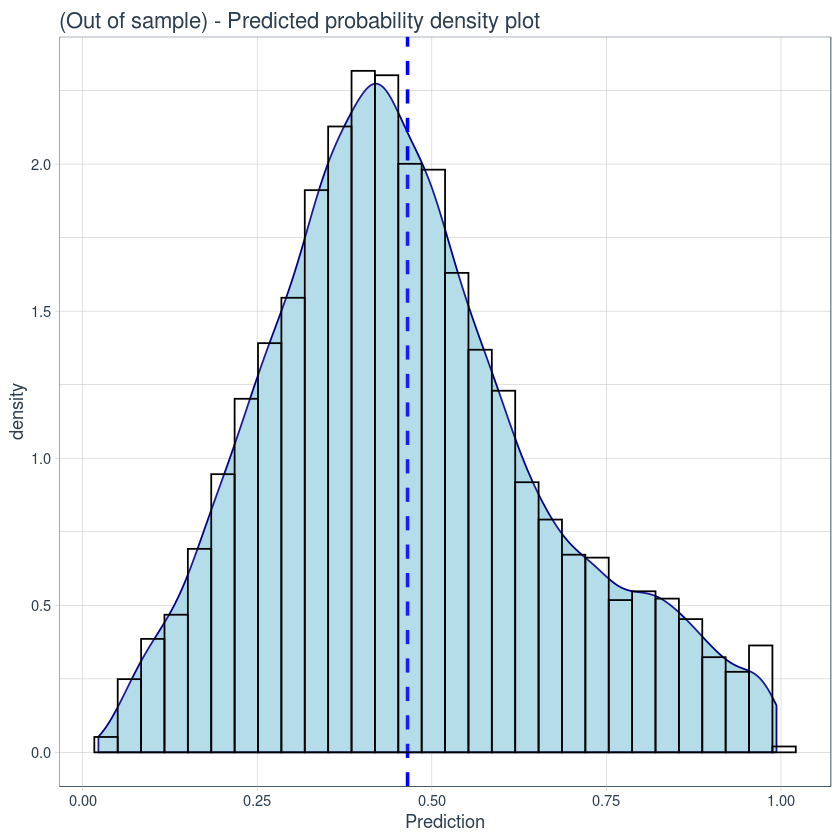

In [23]:
# Make the final predictions on the 'test.csv' data and plot the probability density function.

xgb.pred_final <- predict(xgb.model_final, dtest_final, type = 'prob')

xgb.pred_final %>%
 as_tibble() %>%
 setNames(c("Prediction")) %>%
 ggplot(aes(x = Prediction)) + 
 geom_density(color = "darkblue", fill = "lightblue") +
 geom_vline(aes(xintercept = mean(Prediction)),
            color = "blue", linetype = "dashed", size = 1) +
 geom_histogram(aes(y = ..density..), colour = "black", fill = "white", alpha = 0.1, position = "identity") +
 ggtitle("(Out of sample) - Predicted probability density plot") +
 theme_tq()

In [33]:
# Convert the probabilities into a binary class of 0 or 1 by a decision threshold of 0.465.
# Write the predictions to "submission.csv"

xgb.pred_final %>%
  as_tibble() %>%
  setNames(c("Prediction")) %>%
  summarise(mean = mean(Prediction))

xgb.pred_final %>%
  as_tibble() %>%
  setNames(c("Prediction")) %>%
  mutate(pred = case_when(
    Prediction > 0.465 ~ 1,
    Prediction <= 0.465 ~ 0
  )) %>%
  write.csv("submission.csv")

mean
<dbl>
0.4652583


# ------------------- END FILE -----------------

Final footnote: Hopefully the out-of-sample predictions will obtain a 67% accuracy (the predictions in the "submission.csv" file).
